In [1]:
# # google colab + google drive sync
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !ls
# %cd gdrive/MyDrive/Colab Notebooks/G-ABC-Infection/AI-Infection-main

# # library install
# !pip install gpytorch
# # requirements.txt file generation
# !pip freeze > requirements.txt

In [4]:
import pandas as pd
import numpy as np
import xlrd
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import os
import random
from gpytorch.mlls import SumMarginalLogLikelihood
from itertools import repeat

In [5]:
''' fix random seed for reproduce '''
random_seed = 1000
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

데이터 로드 및 전처리

In [4]:
file_name_date = '20231231'
start_date = pd.Timestamp('2020-01-01')        
data_start_date = pd.Timestamp('2020-01-22')   # 확진자, 사망자 데이터 시작일
observed_end_date = pd.Timestamp('2021-10-04') # "사망자 데이터 통합"등에 기록된 최종 일자
pre_date = pd.Timestamp('2021-10-05')          # 예측 시작 날짜
end_date = pd.Timestamp('2023-12-31')
test_date = pd.date_range(observed_end_date,end_date)
date = pd.date_range(start_date,end_date)

In [5]:
date

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=1461, freq='D')

In [6]:
''' data read '''
path_ = '../../../../11_data/국제/수집데이터_211105.xlsx'
x_holiday = pd.read_excel(path_,sheet_name='국가별공휴일',engine='openpyxl')
x_dist = pd.read_excel(path_,sheet_name='사회적거리두기_Score',engine='openpyxl')
x_vaccine = pd.read_excel(path_,sheet_name='백신접종자수',engine='openpyxl')
x_weather = pd.read_excel(path_,sheet_name='국가별수도날씨',engine='openpyxl')
x_population = pd.read_excel(path_,sheet_name='국가별인구수',engine='openpyxl')
x_variant = pd.read_excel(path_,sheet_name='변이바이러스 비율',engine='openpyxl')
y_inspection = pd.read_excel(path_,sheet_name='검사자 데이터 통합',engine='openpyxl')
y_severity = pd.read_excel(path_,sheet_name='확진자 관리현황',engine='openpyxl')
y_infection = pd.read_excel(path_,sheet_name='확진자 데이터 통합',engine='openpyxl')
y_death = pd.read_excel(path_,sheet_name='사망자 데이터 통합',engine='openpyxl')

In [7]:
## 확진자 튀는 데이터...
y_infection = y_infection.fillna(0)
y_death = y_death.fillna(0)
y_infection.loc[y_infection['tDate']=='2021-09-26','South Korea']= 2771
y_infection.loc[y_infection['tDate']=='2021-10-04','South Korea']= 1673

## 확진자, 사망자 -999 -> 0
y_infection.loc[y_infection['South Korea']== -999,'South Korea']= 0
y_death.loc[y_death['South Korea']== -999,'South Korea']= 0

In [8]:
country_list = y_inspection.columns.values.tolist()[1:]
country_idx_dict = {key:val for val,key in enumerate(country_list)}

num_country = len(country_list)
td = (end_date - start_date).days + 1 # total date, 2020-01-02 - 2020-01-01 = 1

# GP에 넣기 위한 빈공간 생성
x = np.zeros((6,num_country,td)) # 6: 날짜 + 위 셀에서 불러온 데이터 x 5개 (국가별인구수는 제외)
y = np.zeros((3,num_country,td)) # 3: 검사자, 확진자, 사망자

In [9]:
# 인구수
country_population_dict = {}
for row in x_population.iterrows():
  country, pro1, pro2, num = row[1]
  if type(pro1) == float:
    country_population_dict[country] = num
country_population_dict['Czechia'] = 10650000
country_population_dict['Latvia'] = 1920000
country_population_dict['US'] = 328200000

In [10]:
# 날짜 
# 규칙: 0,1,2,3,4,...
for itr in range(td):
  x[0,:,itr] = itr 

In [11]:
# x_holiday 전처리
# 규칠: 공휴일:1 , 그 외: 0
for row in x_holiday.iterrows():
  current_date, country, _ = row[1]
  idx = (current_date - start_date).days
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[1,country_idx_dict[country],idx] = 1

In [12]:
# x_dist 전처리
# 규칙: 항목별 score 평균 (province별로 존재할 경우, 이 또한 평균)
country_end_dict = {}
group_x_dist = x_dist.groupby(['tDate', 'Country']).mean() # province별로 존재할 경우, 평균
for row in group_x_dist.iterrows():
  current_date, country = row[0]
  idx = (current_date - start_date).days
  dist = np.mean(row[1])
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    if (dist == 0) and (idx>0): # 관측되었지만, 0으로 누락된 경우를 고려하기 위함
      x[2,country_idx_dict[country],idx] = x[2,country_idx_dict[country],idx-1]
    else:
      x[2,country_idx_dict[country],idx] = dist
  country_end_dict[country] = idx
  
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[2,country_idx_dict[country],itr] = x[2,country_idx_dict[country],country_end_idx]

In [13]:
# x_vaccine 전처리
# 규칙: 1차 백신 접종자수만 기록하되, 누적하여 기록 (0으로 결측일 경우, 그 이전 max 값 그대로 가져오기)
# 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
country_end_dict = {}
for row in x_vaccine.iterrows():
  current_date, country, num_vaccine, _ = row[1]
  idx = (current_date - start_date).days
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[3,country_idx_dict[country],idx] = np.maximum(num_vaccine, x[3,country_idx_dict[country],idx-1])
  country_end_dict[country] = idx

# 각 국가별 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[3,country_idx_dict[country],itr] = x[3,country_idx_dict[country],country_end_idx]

In [14]:
# x_weather 전처리21
# 규칙: Temp만 기록, city 별로는 평균
# 최신날짜부터, 2021-12-31까지는 1년전 값 유지
group_x_weather = x_weather.groupby(['tDate', 'Country']).mean() # province별로 존재할 경우, 평균
for row in group_x_weather.iterrows():
  current_date, country = row[0]
  idx = (current_date - start_date).days
  temp = row[1][0]
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[4,country_idx_dict[country],idx] = temp
for itr in range(idx,td):
  x[4,:,itr] = x[4,:,itr-365]

In [15]:
# x_variant 전처리
# 규칙: 21A.Delta 기록
# 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
# 중간 중간 빈 값은, 그 이전 값을 그대로 유지
country_end_dict = {}
prev_idx = 0
for row in x_variant.iterrows():
  country, current_date,variant,_,_,proportion = row[1]
  if variant == '21A.Delta':
    idx = (current_date - start_date).days
    if (idx >= 0) and (idx < td) and (country in country_idx_dict):
      x[5,country_idx_dict[country],prev_idx+1:idx+1] = proportion
    prev_idx = idx
    country_end_dict[country] = idx

# 각 국가별 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[5,country_idx_dict[country],itr] = x[5,country_idx_dict[country],country_end_idx]

In [16]:
# y 전처리
for country,country_idx in country_idx_dict.items():
  country_inspection = y_inspection[country]
  country_infection = y_infection[country]
  country_death = y_death[country]

  y[0,country_idx,:len(country_inspection)] = country_inspection # from 2020-01-01
  y[1,country_idx,21:21+len(country_death)] = country_infection # from 2020-01-22
  y[2,country_idx,21:21+len(country_death)] = country_death # from 2020-01-22



In [17]:
country_idx_dict

{'Australia': 0,
 'Austria': 1,
 'Belgium': 2,
 'Canada': 3,
 'Chile': 4,
 'China': 5,
 'Colombia': 6,
 'Costa Rica': 7,
 'Czechia': 8,
 'Denmark': 9,
 'Estonia': 10,
 'Finland': 11,
 'France': 12,
 'Germany': 13,
 'Greece': 14,
 'Hungary': 15,
 'Iceland': 16,
 'Ireland': 17,
 'Israel': 18,
 'Italy': 19,
 'Japan': 20,
 'Latvia': 21,
 'Lithuania': 22,
 'Luxembourg': 23,
 'Mexico': 24,
 'Netherlands': 25,
 'New Zealand': 26,
 'Norway': 27,
 'Poland': 28,
 'Portugal': 29,
 'Slovakia': 30,
 'Slovenia': 31,
 'South Korea': 32,
 'Spain': 33,
 'Sweden': 34,
 'Switzerland': 35,
 'Taiwan': 36,
 'Turkey': 37,
 'United Kingdom': 38,
 'US': 39}

In [18]:
y_severity

,tDate,YesterdayQuarantineRelease,YesterdayQuarantine,YesterdayIllPatient,YesterdayDead,TodayQuarantineRelease,TodayQuarantine,TodayIllPatient,TodayDead,VarianceQuarantineRelease,VarianceQuarantine,VarianceIllPatient,VarianceDead
0,2020-09-15,18489,3433,157,363,18878,3146,158,367,389,-287,1,4
1,2020-09-16,18878,3146,158,367,19310,2827,160,367,432,-319,2,0
2,2020-09-17,19310,2827,160,367,19543,2742,160,372,233,-85,0,5
3,2020-09-18,19543,2742,150,372,19771,2635,150,377,228,-107,-10,5
4,2020-09-19,19771,2635,150,377,19970,2545,152,378,199,-90,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2021-10-02,275576,35699,323,2497,277092,36424,336,2504,1516,725,13,7
383,2021-10-03,277092,36423,336,2504,278847,36751,346,2507,1755,328,10,3
384,2021-10-04,278847,36750,346,2507,282669,34595,348,2513,3822,-2155,2,6
385,2021-10-05,282669,34595,348,2513,284197,34631,346,2524,1528,36,-2,11


In [19]:
# x 최종 전처리 (0~1사이의 범위로 변경)
x[0,:,:] = x[0,:,:]/td # 날짜
x[1,:,:] = x[1,:,:] # 그대로 0,1
x[2,:,:] = x[2,:,:]/100 # 거리두기 score
for country,country_idx in country_idx_dict.items():
  x[3,country_idx,:] = x[3,country_idx,:]/country_population_dict[country] # vaccine
x[4,:,:] = x[4,:,:]/np.max(x[4,:,:]) # weather
x[5,:,:] = x[5,:,:] # variant

In [20]:
# y 최종 전처리 (0~1사이의 범위로 변경)
max_list = []
for country,country_idx in country_idx_dict.items():
  max_list.append([np.max(y[0,country_idx,:]),np.max(y[1,country_idx,:]),np.max(y[2,country_idx,:])])
  y[0,country_idx,:] = y[0,country_idx,:]/np.max(y[0,country_idx,:]) # inspection
  y[1,country_idx,:] = y[1,country_idx,:]/np.max(y[1,country_idx,:]) # infection
  y[2,country_idx,:] = y[2,country_idx,:]/np.max(y[2,country_idx,:]) # death
  # y[0,country_idx,:] = y[0,country_idx,:]/country_population_dict[country] # inspection
  # y[1,country_idx,:] = y[1,country_idx,:]/country_population_dict[country] # infection
  # y[2,country_idx,:] = y[2,country_idx,:]/country_population_dict[country] # death

/home/sysadm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/sysadm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [21]:
# numpy to pytorch tensor
torch_x = torch.from_numpy(x).float()
torch_y = torch.from_numpy(y).float()
print(x.shape,y.shape,torch.max(torch_x),torch.max(torch_y[2,:,:]))

(6, 40, 1461) (3, 40, 1461) tensor(1.) tensor(1.)


In [22]:
# train, test split
start_point = (pd.Timestamp('2020-09-01') - start_date).days # we remove data before 2020-09-01, many values are one or zero
# start_point = 366 # 2021-01-01 0~29: many values are one or zero
end_point = (observed_end_date-start_date).days

train_date = date[start_point:end_point]
train_x = torch_x[:,:,start_point:end_point]
train_y = torch_y[:,:,start_point:end_point]

test_date = date[end_point:]
test_x = torch_x[:,:,end_point:]
test_y = torch_y[:,:,end_point:]

print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

torch.Size([6, 40, 398]) torch.Size([6, 40, 819]) torch.Size([3, 40, 398]) torch.Size([3, 40, 819])


In [23]:
data_dim = train_x.size(0)
feature_dim = 10
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 64))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(64, 32))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(32, feature_dim))

feature_extractor = LargeFeatureExtractor()

In [24]:
# initialize model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()+gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=10)*gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=6)*gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=feature_dim))
        # self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=5,ard_num_dims=feature_dim)
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)
        self.feature_extractor = feature_extractor

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        projected_x = self.scale_to_bounds(projected_x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [25]:
# initialize likelihood
model_list = []
likelihood_list = []
num_country = len(country_idx_dict)
'''
한국, 영국, 미국에 대해서 multi-output gp
'''
target_country_list = [32,38,39] # South Korea, United Kingdom, UK
for mode_itr in [1,2]: # 1: infection', 2: death
  for itr in range(num_country):
    if itr in target_country_list:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      model = ExactGPModel(train_x[:,itr,:].T, train_y[mode_itr,itr,:], likelihood)
      model_list.append(model)
      likelihood_list.append(model.likelihood)

In [26]:
model = gpytorch.models.IndependentModelList(*model_list)
likelihood = gpytorch.likelihoods.LikelihoodList(*likelihood_list)

In [27]:
# Use the adam optimizer
training_iter = 700
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

In [28]:
# training
model.train()
likelihood.train()

# "Loss" for GPs - the marginal log likelihood
mll = SumMarginalLogLikelihood(likelihood, model)
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()
    if i%10 == 0:
      print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

Iter 1/700 - Loss: 0.768
Iter 11/700 - Loss: 0.724
Iter 21/700 - Loss: 0.686
Iter 31/700 - Loss: 0.648
Iter 41/700 - Loss: 0.609
Iter 51/700 - Loss: 0.569
Iter 61/700 - Loss: 0.528
Iter 71/700 - Loss: 0.486
Iter 81/700 - Loss: 0.444
Iter 91/700 - Loss: 0.401
Iter 101/700 - Loss: 0.356
Iter 111/700 - Loss: 0.312
Iter 121/700 - Loss: 0.266
Iter 131/700 - Loss: 0.220
Iter 141/700 - Loss: 0.175
Iter 151/700 - Loss: 0.128
Iter 161/700 - Loss: 0.082
Iter 171/700 - Loss: 0.034
Iter 181/700 - Loss: -0.007
Iter 191/700 - Loss: -0.058
Iter 201/700 - Loss: -0.107
Iter 211/700 - Loss: -0.153
Iter 221/700 - Loss: -0.201
Iter 231/700 - Loss: -0.235
Iter 241/700 - Loss: -0.287
Iter 251/700 - Loss: -0.335
Iter 261/700 - Loss: -0.380
Iter 271/700 - Loss: -0.418
Iter 281/700 - Loss: -0.466
Iter 291/700 - Loss: -0.505
Iter 301/700 - Loss: -0.534
Iter 311/700 - Loss: -0.578
Iter 321/700 - Loss: -0.622
Iter 331/700 - Loss: -0.664
Iter 341/700 - Loss: -0.701
Iter 351/700 - Loss: -0.730
Iter 361/700 - Loss: 

In [29]:
# testing
concat_train_x = []
concat_test_x = []
for mode_itr in [1,2]:
  for itr in range(num_country):
    if itr in target_country_list:
      concat_train_x.append(train_x[:,itr,:].T)
      concat_test_x.append(test_x[:,itr,:].T)

model.eval()
likelihood.eval()
estimations = likelihood(*model(*concat_train_x))
predictions = likelihood(*model(*concat_test_x))

/home/sysadm/anaconda3/envs/heytrt3.7/lib/python3.6/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


In [30]:
y_infection.iloc[:,[0,33]]

,tDate,South Korea
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,1
3,2020-01-25,0
4,2020-01-26,1
...,...,...
623,2021-10-08,2172
624,2021-10-09,1949
625,2021-10-10,1594
626,2021-10-11,1297


In [34]:
y_infection.to_csv('../../../../03_result/GP/211102/gp_211102_i.csv')
y_death.to_csv('../../../../03_result/GP/211102/gp_211102_d.csv')
y_severity.to_csv('../../../../03_result/GP/211102/gp_211102_s.csv')

In [35]:
y_severity

,tDate,YesterdayQuarantineRelease,YesterdayQuarantine,YesterdayIllPatient,YesterdayDead,TodayQuarantineRelease,TodayQuarantine,TodayIllPatient,TodayDead,VarianceQuarantineRelease,VarianceQuarantine,VarianceIllPatient,VarianceDead
0,2020-09-15,18489,3433,157,363,18878,3146,158,367,389,-287,1,4
1,2020-09-16,18878,3146,158,367,19310,2827,160,367,432,-319,2,0
2,2020-09-17,19310,2827,160,367,19543,2742,160,372,233,-85,0,5
3,2020-09-18,19543,2742,150,372,19771,2635,150,377,228,-107,-10,5
4,2020-09-19,19771,2635,150,377,19970,2545,152,378,199,-90,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2021-10-02,275576,35699,323,2497,277092,36424,336,2504,1516,725,13,7
383,2021-10-03,277092,36423,336,2504,278847,36751,346,2507,1755,328,10,3
384,2021-10-04,278847,36750,346,2507,282669,34595,348,2513,3822,-2155,2,6
385,2021-10-05,282669,34595,348,2513,284197,34631,346,2524,1528,36,-2,11


In [32]:
def plot_figure(target_country,mode):
  target_country_population = country_population_dict[target_country]
  name = file_name_date+'_None_None_None'
  if mode == 1:
    folder_name = 'I/'
    if target_country == 'South Korea':
      data = y_infection.iloc[:,[0,33]]
      target_country_idx = 0
      y_lim = [-300,4500]
    elif target_country == 'United Kingdom':
      target_country_idx = 1
      y_lim = [-1000,80000]
    elif target_country == 'US':
      target_country_idx = 2
      y_lim = [-1000,450000]
  elif mode == 2:
    folder_name = 'D/'
    if target_country == 'South Korea':
      data = y_death.iloc[:,[0,33]]
      target_country_idx = 3
      y_lim = [-10,70]
    elif target_country == 'United Kingdom':
      target_country_idx = 4
      y_lim = [-1000,3000]
    elif target_country == 'US':
      target_country_idx = 5
      y_lim = [-1666,5000]

  submodel = model.models[target_country_idx]
  estimation = estimations[target_country_idx]
  prediction = predictions[target_country_idx]
  max_value = max_list[country_idx_dict[target_country]][mode]

  lower, upper = prediction.confidence_region()
  tr_x = submodel.train_inputs[0].detach().numpy()[:,0]
  tr_y = submodel.train_targets.detach().numpy()
  
  ## Ground-Truth
  data = data.fillna(0)

##여기서부터 그래프 그리기 
################스타일#######################################
  fig = plt.figure(figsize=(40,15)) ## 캔버스 생성
  fig.patch.set_facecolor('#050636') 
  plt.rcParams['text.color'] = 'w'
  plt.rcParams['xtick.color'] = 'w'
  plt.rcParams['ytick.color'] = 'w'
  plt.rcParams['axes.spines.left'] = True
  plt.rcParams['axes.facecolor']='#050636'
  plt.grid(color='w', linestyle='-', linewidth=3,alpha = 0.5)
  plt.gca().spines['bottom'].set_visible(True) #위 테두리
  plt.gca().spines['left'].set_visible(True) #왼쪽 테두리
#############################################################
  # Plot training data as black stars
#   plt.plot(tr_x, tr_y*max_value,color = '#2dcafd', linewidth = 6)


  # Plot Ground-Truth
#   plt.plot(y, tr_y*max_value,color = '#2dcafd', linewidth = 6)
  plt.plot(data.loc[data['tDate']<=pre_date,'tDate'], data.loc[data['tDate']<=pre_date,'South Korea'],color = '#2dcafd', linewidth = 6)

  # Predictive mean as blue line
#   plt.plot(train_x[0,country_idx_dict[target_country],:].numpy(), estimation.mean.numpy()*max_value, 'b')
  plt.plot(test_date, prediction.mean.numpy()*max_value, color ='#f13eab', linewidth = 6)
  

  # Shade in confidence
  plt.fill_between(test_date, 
                        lower.detach().numpy()*max_value, 
                        upper.detach().numpy()*max_value, color = '#d974c7',alpha=0.5)
  plt.ylim(y_lim)
#   plt.legend(['Observed Data', 'Mean', 'Confidence'])
#   plt.title('Observed Values (Likelihood)')
  plt.legend(['Ground-Truth', 'Prediction','Confidence'],fontsize=30,loc = 'upper left', edgecolor = 'w') #왜 이게 적용안되지?
#   plt.ylabel(name)

#   y_loc = y_lim[0]*1.5


  plt.xticks([data_start_date,'2020-06-01','2020-11-01','2021-05-01',pre_date,'2022-04-01','2022-09-01','2023-03-01','2023-08-01',end_date],[str(data_start_date)[:10],'2020-06','2020-11','2021-05',str(pre_date)[:10],'2022-04','2022-09','2023-03','2023-08',str(end_date)[:10]],fontsize=30)

  plt.yticks(fontsize = 30)
  plt.axvline(x=pre_date,linestyle = ':',color='w',linewidth=8, alpha = 0.7)

  plt.tight_layout()
  plt.savefig('../../../../04_image/211102/211102/TSA/GP/'+folder_name+str(name),dpi=300)
  plt.show()

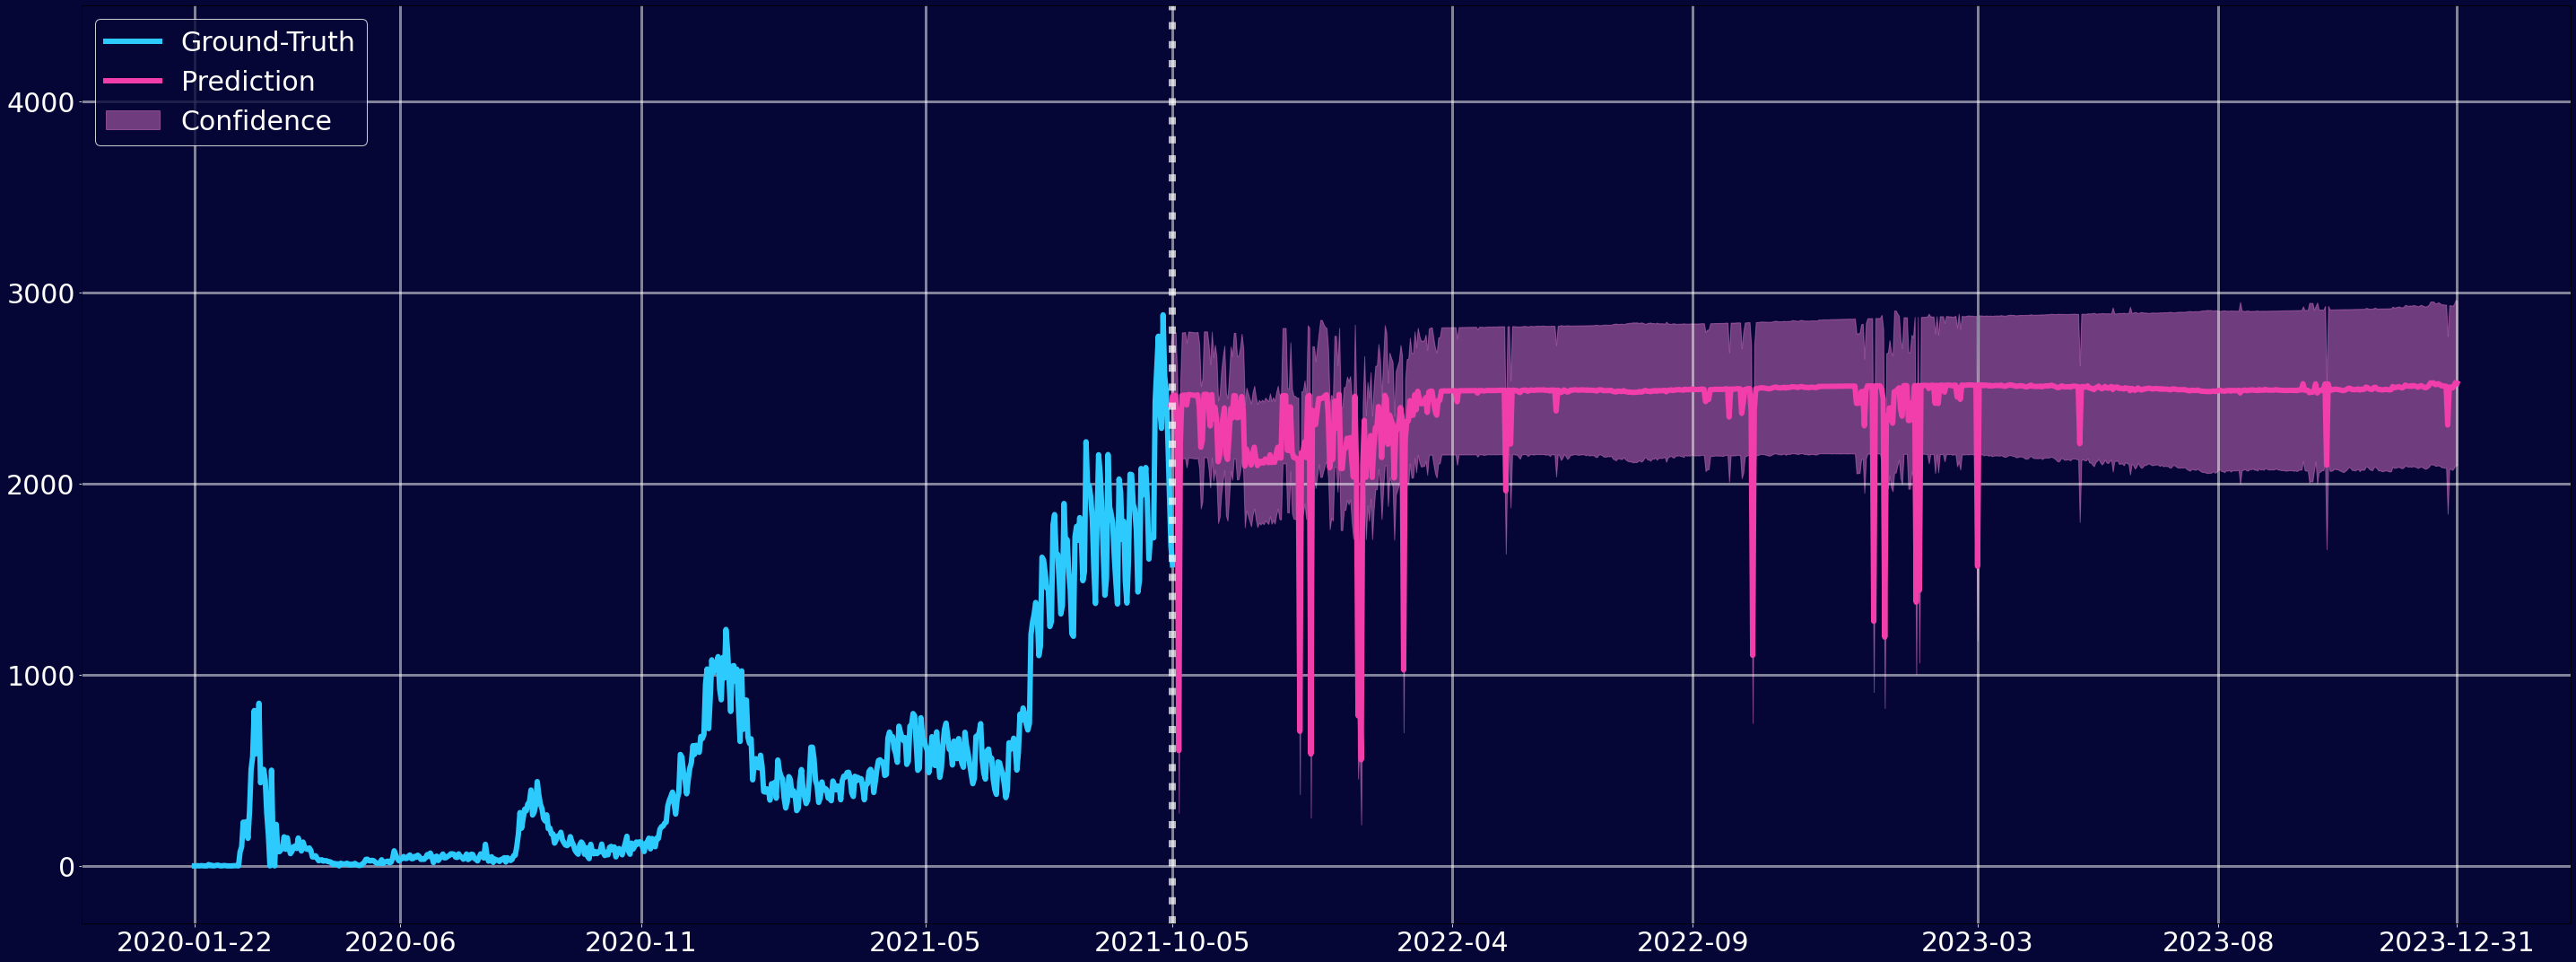

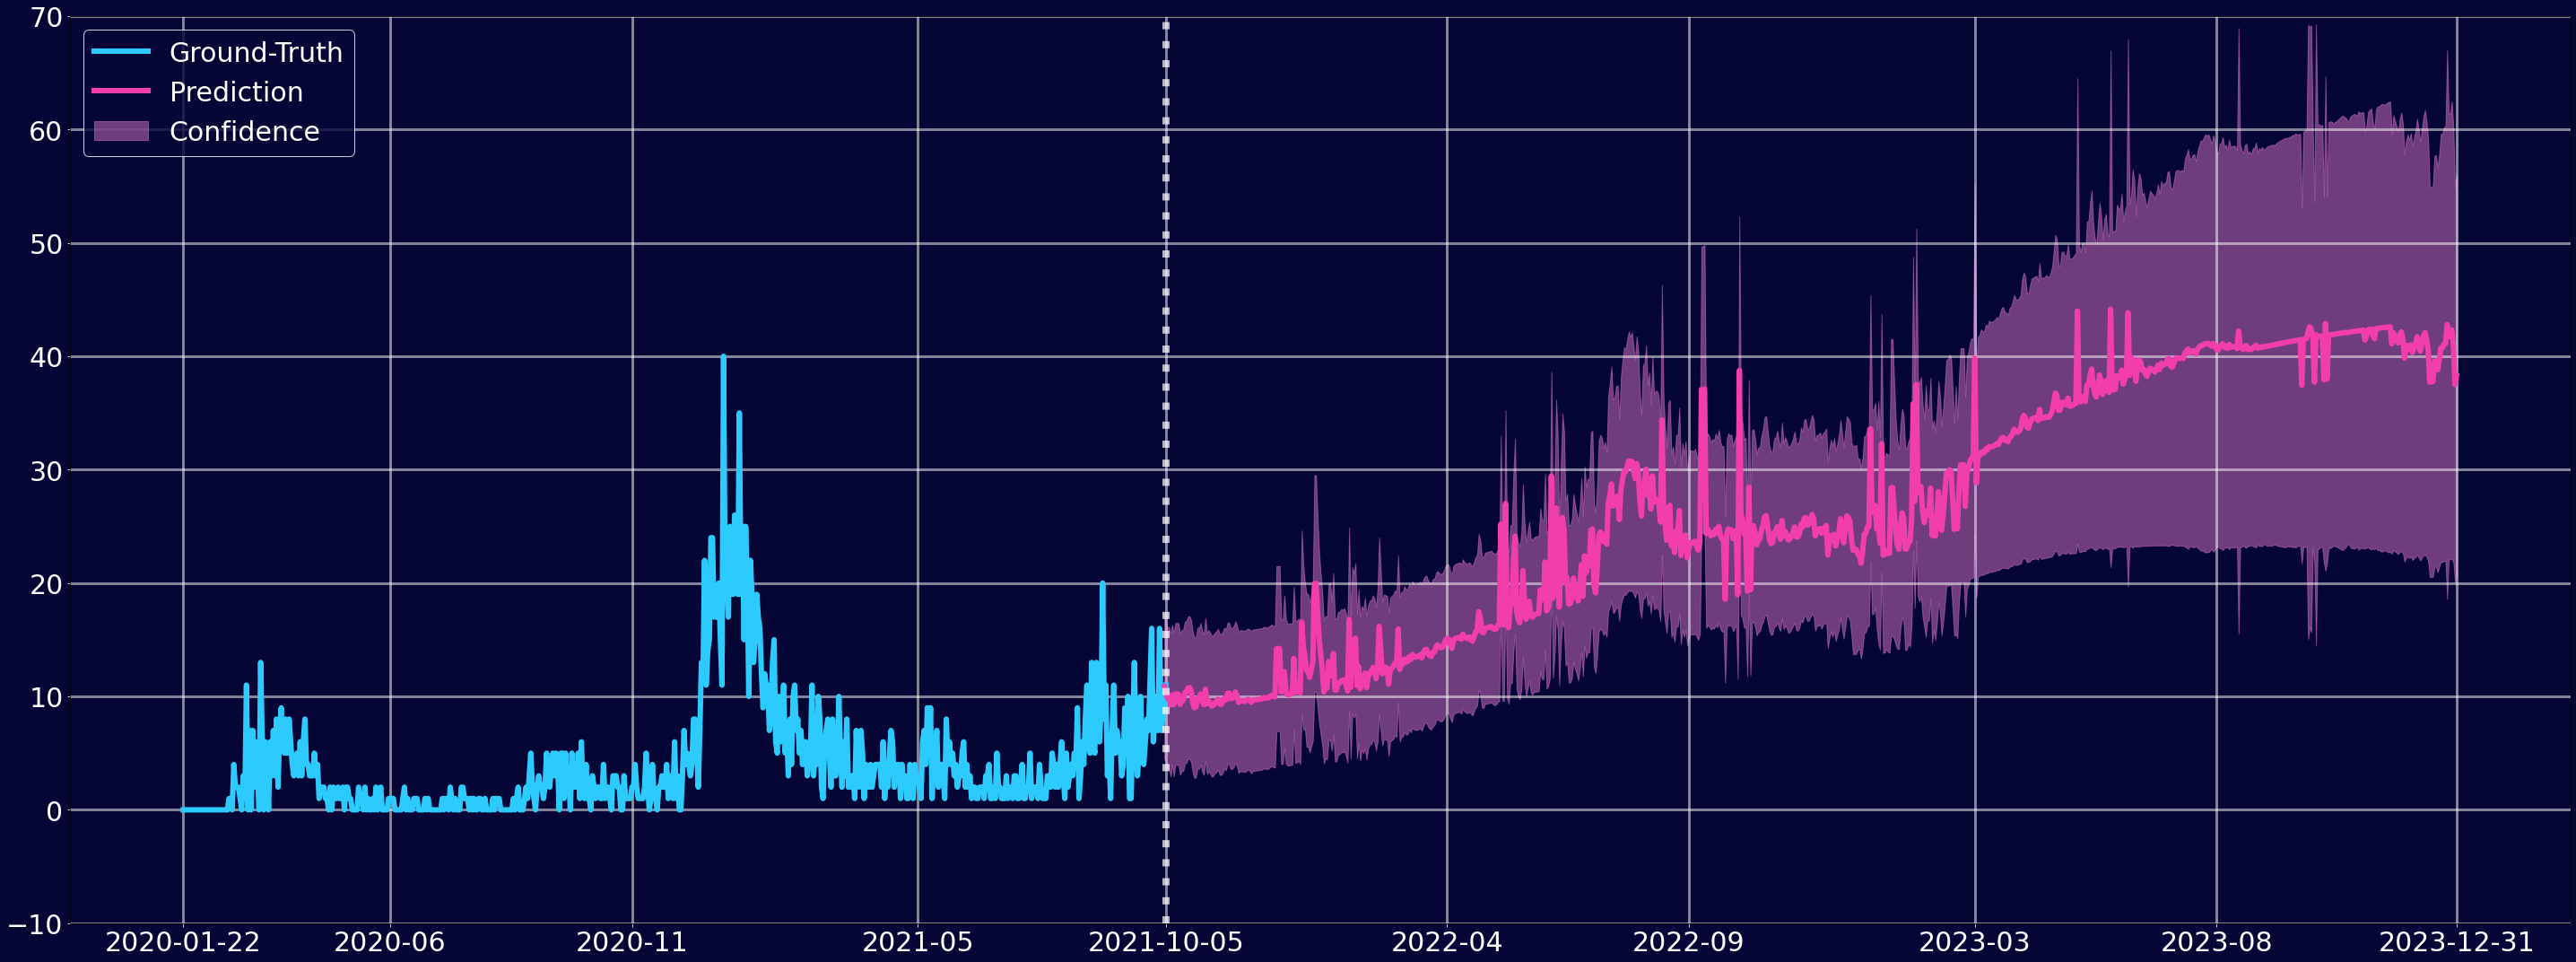

In [33]:
# visualization
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  target_country_list = ['South Korea','United Kingdom','US']
  mode_list = [1,2] # 1: infection', 2: death

  for target_country in target_country_list:
    if target_country == target_country_list[0]:
        for mode in mode_list: 
          plot_figure(target_country,mode)